# UBC Ovarian Cancer Subtype Classification and Outlier Detection (UBC-OCEAN) with [KerasCV](https://github.com/keras-team/keras-cv) and [Keras](https://github.com/keras-team/keras)

> Your challenge in this competition is to classify the type of ovarian cancer from microscopy scans of biopsy samples.

This notebook walks you through how to train a **Convolutional Neural Network (CNN)** model (here ResNet) using KerasCV on the UBC-OCEAN dataset made available for this competition. In this notebook we specifically train on the `thumbnail` images provided.

Fun fact: This notebook is backend (tensorflow, pytorch, jax) agnostic. Using KerasCV and Keras we can choose a backend of our choise! Feel free to read on [Keras](https://keras.io/keras_core/announcement/) to know more.

In this notebook you will learn:

* Loading the data using [`tf.data`](https://www.tensorflow.org/guide/data).
* Create the model using KerasCV presets.
* Train the model.
* Submit to the competition.

**Note**: [KerasCV guides](https://keras.io/guides/keras_cv/) is the place to go for a deeper understanding of KerasCV individually.

## Setup and Imports

Keras is backend agnostic. This means that you can run keras on [TensorFlow](https://www.tensorflow.org/), [JAX](https://jax.readthedocs.io/en/latest/index.html), [PyTorch](https://pytorch.org/), or [Numpy](https://numpy.org/) (inference only). We will be using JAX as our backend. To switch backends set the `KERAS_BACKEND` varialbe to which backend to want.

In [1]:

import os
os.environ["KERAS_BACKEND"] = "jax" # or "tensorflow", "torch"

import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

import tensorflow as tf
import keras_cv
import keras_core as keras
from keras_core import ops

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import SGD




Using JAX backend.


In [2]:
class Config:
    is_submission = False
    # Reproducibility
    SEED = 42
    
    # Training
    train_csv_path = "/kaggle/input/UBC-OCEAN/train.csv"
    train_thumbnail_paths = "/kaggle/input/UBC-OCEAN/train_thumbnails"
    batch_size = 8
    learning_rate = 0.001
    epochs = 2
    
    # Inference
    test_csv_path = "/kaggle/input/UBC-OCEAN/test.csv"
    test_thumbnail_paths = "/kaggle/input/UBC-OCEAN/test_thumbnails"

config = Config()

To help with reproducibility we set the seed of the Pseudo Random Number Generator.

In [3]:
keras.utils.set_random_seed(seed=config.SEED)

# Training

## Dataset

In this notebook we train on the thumbnails for quick iteration. Also note that we are NOT going to work on the anomaly detection part of the competition here. We will train a simple image classification model that will classify the scans of biopsy samples to their respective subtypes.

num_rows=513
num_unique_images=513
num_unique_labels=5
unique_labels=array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)


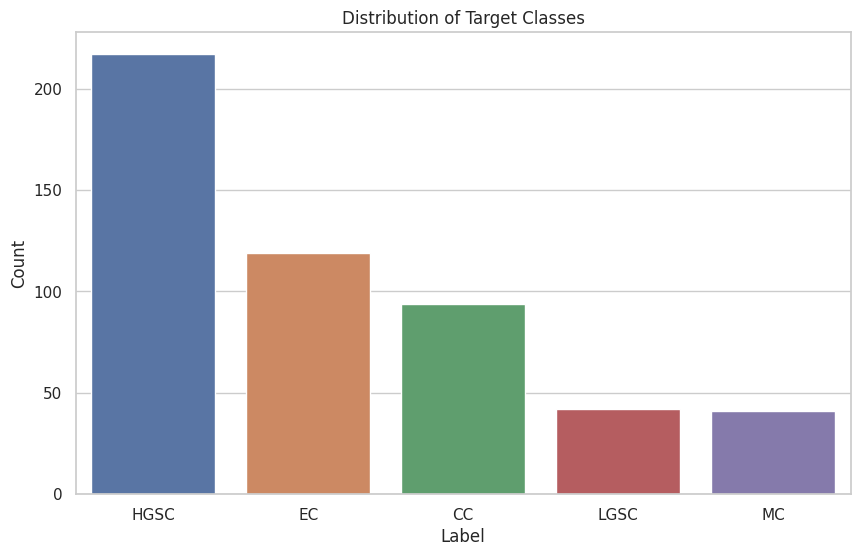

In [4]:
if not config.is_submission:
    df = pd.read_csv(config.train_csv_path)

    # Create the thumbnail df where is_tma == False
    df = df[df["is_tma"] == False]
    
    # Get basic statistics about the dataset
    num_rows = df.shape[0]
    num_unique_images = df['image_id'].nunique()
    num_unique_labels = df['label'].nunique()
    unique_labels = df['label'].unique()

    print(f"{num_rows=}")
    print(f"{num_unique_images=}")
    print(f"{num_unique_labels=}")
    print(f"{unique_labels=}")
    
    # Plot the distribution of the target classes
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
    plt.title('Distribution of Target Classes')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

Note the imbalance in the distribution of target classes.

## Perform one-hot encoding

In [5]:
if not config.is_submission:
    # Perform one-hot encoding of the 'label' column and explicitly convert to integer type
    df_one_hot = pd.get_dummies(df["label"], prefix="label").astype(int)

    # Concatenate the original DataFrame with the one-hot encoded labels
    train_df = pd.concat([df["image_id"], df_one_hot], axis=1)

    # Get the thumbnail image paths
    train_df["image_thumbnail_path"] = train_df["image_id"].apply(lambda x: f"{config.train_thumbnail_paths}/{x}_thumbnail.png")
    
    image_thumbnail_paths = train_df["image_thumbnail_path"].values
    labels = train_df[[col for col in train_df.columns if col.startswith("label_")]].values

    label_names = [col for col in train_df.columns if col.startswith("label_")]
    name_to_id = {key.replace("label_", ""):value for value,key in enumerate(label_names)}
    id_to_name = {key:value for value, key in name_to_id.items()}

    # Save to dictionary to disk
    with open("id_to_name.pkl", "wb") as f:
        pickle.dump(id_to_name, f)

Taking pointers from the [image classification on imbalanced dataset guide](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data), we create the class weights which will be used to train the model.

In [6]:
if not config.is_submission:
    class_weights = np.sum(labels) - np.sum(labels, axis=0)
    class_weights = class_weights / np.sum(class_weights) # Normalize the weights

    class_weights = {idx:weight for idx, weight in enumerate(class_weights)}

    for idx, weight in class_weights.items():
        print(f"{id_to_name[idx]}: {weight:0.2f}")

CC: 0.20
EC: 0.19
HGSC: 0.14
LGSC: 0.23
MC: 0.23


## Creating the `tf.data.Dataset` pipeline

In [7]:
def read_image(path):
    file = tf.io.read_file(path)
    image = tf.io.decode_png(file, 3)
    image = tf.image.resize(image, (224, 224))
    image = tf.image.per_image_standardization(image)
    return image

In [8]:
if not config.is_submission:
    x = (
        tf.data.Dataset.from_tensor_slices(image_thumbnail_paths)
        .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    )
    y = tf.data.Dataset.from_tensor_slices(labels)

    # Zip the x and y together
    ds = tf.data.Dataset.zip((x, y))
    
    # Create the training and validation splits
    val_ds = (
        ds
        .take(50)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    train_ds = (
        ds
        .skip(50)
        .shuffle(config.batch_size * 10)
        .batch(config.batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

Visualizing the dataset is always fruitful. Below we will sample from the dataset and visualize some images.

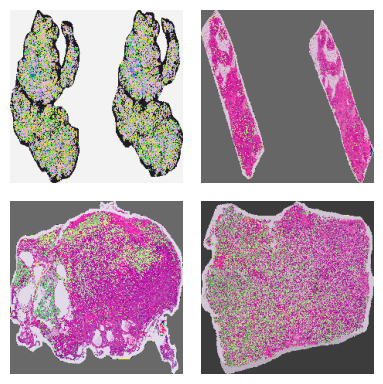

In [9]:
if not config.is_submission:
    images, labels = train_ds.take(1).get_single_element()

    keras_cv.visualization.plot_image_gallery(
        images,
        value_range=(0, 1),
        rows=2,
        cols=2,
    )

## Build the Model

[List of Keras CV models](https://keras.io/api/keras_cv/models/)

In [10]:
# # Load the image and text backbones with presets
# resnet_backbone = keras_cv.models.ResNetV2Backbone.from_preset(
#     "resnet152_v2",
# )
# resnet_backbone.trainable = False

# image_inputs = resnet_backbone.input
# image_embeddings = resnet_backbone(image_inputs)
# image_embeddings = keras.layers.GlobalAveragePooling2D()(image_embeddings)

# x = keras.layers.BatchNormalization(epsilon=1e-05, momentum=0.1)(image_embeddings)
# x = keras.layers.Dense(units=1024, activation="relu")(x)
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(units=512, activation="relu")(x)
# x = keras.layers.Dropout(0.1)(x)
# x = keras.layers.Dense(units=256, activation="relu")(x)
# outputs = keras.layers.Dense(units=5, activation="softmax")(x)

# # Build the model with the Functional API
# model = keras.Model(
#     inputs=image_inputs,
#     outputs=outputs,
# )

# model.summary()

# Specify the local path to the DenseNet201 weights file
weights_path = '/kaggle/input/densenet-h5/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load DenseNet201 as the backbone with custom weights path
densenet_backbone = DenseNet201(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
densenet_backbone.trainable = False  # Freeze the weights of the pre-trained model

# Create a custom head for classification
image_inputs = densenet_backbone.input
image_embeddings = densenet_backbone(image_inputs)
image_embeddings = GlobalAveragePooling2D()(image_embeddings)

x = BatchNormalization(epsilon=1e-05, momentum=0.1)(image_embeddings)
x = Dense(units=1024, activation="relu")(x)
x = Dropout(0.5)(x)  # Adjust dropout rate
x = Dense(units=512, activation="relu")(x)
x = Dropout(0.5)(x)  # Adjust dropout rate
x = Dense(units=256, activation="relu")(x)
outputs = Dense(units=5, activation="softmax")(x)

# Build the model with the Functional API
model = Model(inputs=image_inputs, outputs=outputs)

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1967104   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [11]:

if not config.is_submission:
    model.compile(
        optimizer=Adam(learning_rate=config.learning_rate),
        loss=CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    history = model.fit(
        train_ds,
        epochs=config.epochs,
        validation_data=val_ds,
        class_weight=class_weights,
    )


    # Define the directory path
    save_directory = '/kaggle/output'
        
    # Create the directory if it doesn't exist
    os.makedirs(save_directory, exist_ok=True)

    # Save the model weights
    model.save_weights(os.path.join(save_directory, 'model_weights.h5'))



Epoch 1/2
58/58 [==============================] - 126s 2s/step - loss: 0.3654 - accuracy: 0.3045 - val_loss: 1.8913 - val_accuracy: 0.2600
Epoch 2/2
58/58 [==============================] - 104s 2s/step - loss: 0.2775 - accuracy: 0.4428 - val_loss: 1.3884 - val_accuracy: 0.4400


**confusion matrix **

7/7 [==============================] - 14s 1s/step
Confusion Matrix:
[[ 1  1  2  1  1]
 [ 0  0  3  3  1]
 [ 0  6 16  5  0]
 [ 0  1  3  1  0]
 [ 0  0  1  0  4]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.00      0.00      0.00         7
           2       0.64      0.59      0.62        27
           3       0.10      0.20      0.13         5
           4       0.67      0.80      0.73         5

    accuracy                           0.44        50
   macro avg       0.48      0.35      0.35        50
weighted avg       0.54      0.44      0.45        50



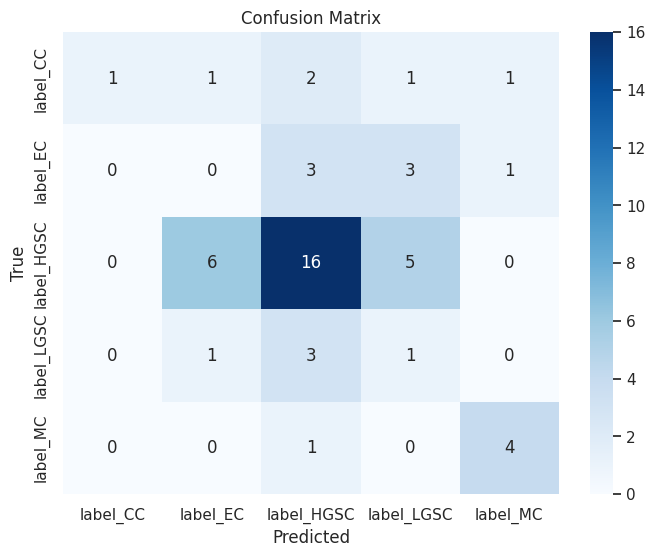

In [12]:
if not config.is_submission:
    
    # Make predictions on the validation dataset
    predictions = model.predict(val_ds)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Extract true labels
    true_labels = np.concatenate([y for x, y in val_ds], axis=0)
    true_labels = np.argmax(true_labels, axis=1)

    # Construct the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Display the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Display the classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels , zero_division = 1))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

## Inference

In [13]:
config.is_submission = True

if config.is_submission:
    df = pd.read_csv(config.test_csv_path)
    df["image_path"] = df["image_id"].apply(lambda x: f"{config.test_thumbnail_paths}/{x}_thumbnail.png")
    directory_path = '/kaggle/output/model_weights.h5'
    
    # Check if the directory exists
    if os.path.exists(directory_path):
        print(f"The directory '{directory_path}' exists.")



    else:
        print(f"The directory '{directory_path}' does not exist.")
        # Load the model weights
    model.load_weights('/kaggle/output/model_weights.h5')

    
    # Load the id to name dictionary
    with open("/kaggle/working/id_to_name.pkl", "rb") as f:
        id_to_name = pickle.load(f)
        


The directory '/kaggle/output/model_weights.h5' exists.


In [14]:
config.is_submission = True
if config.is_submission:
    predicted_labels = []

    for index, row in df.iterrows():
        # Get the image path
        image_path = row["image_path"]

        # Get the image
        image = read_image(image_path)[None, ...]

        # Predict the label
        logits = model.predict(image)
        pred = ops.argmax(logits, axis=-1).tolist()[0]

        # Map the pred to the name
        label = id_to_name[pred]

        predicted_labels.append(label)

    # Add the predicted labels to the csv
    df["label"] = predicted_labels
    


1/1 [==============================] - 5s 5s/step


In [15]:
config.is_submission = True
if config.is_submission:
    # Create the submission
    submission_df = df[["image_id", "label"]]
#     submission_df.to_csv("/kaggle/output/submission.csv", index=False)


    # Define the directory path
    output_directory = '/kaggle/working/'

    # Create the directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Save the CSV file
    submission_df.to_csv(os.path.join(output_directory, 'submission.csv'), index=False)


# Directions Ahead

There are a lot of directions one can take to iterate on top of this starter notebook. Some of them are:

- Play with the various hyperparameters (in the configuration) to get better results
- Come up with a strategy for anomaly detection
- Use different models from the Keras CV presets